# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import os
from skimage.transform import resize
import datetime
import os
import math
import matplotlib.pyplot as plt
from PIL import Image

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 64

In [7]:
train_doc.shape

(663,)

In [6]:
# Define x (number of frames), y (height) and z (width) 
x = 30
y = 120
z = 120
channel = 3

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
def generate_batch(source_path, t, batch, batch_size, x, y, z, channel, img_idx, augment=False, cropimage=False):
    batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            image = image.resize((y,z))
            image = np.asarray(image)
            if cropimage and image.shape[0] > 100 and image.shape[1] > 100:
                h, w, _ = image.shape
                image = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
                
            #Normalize data
            batch_data[folder,idx,:,:,0] = image[:,:,0]/255
            batch_data[folder,idx,:,:,1] = image[:,:,1]/255
            batch_data[folder,idx,:,:,2] = image[:,:,2]/255
            
            if (augment):
                shifted = cv2.warpAffine(image, 
                                         np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))

                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]

                image_resized=resize(cropped,(y,z,channel))

                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
            
    return batch_data, batch_labels
                
def generator(source_path, folder_list, batch_size, augment=False, cropimage=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size, ';foldersize = ', len(folder_list))
    img_idx = [x for x in range(0,x,2)] #create a list of image numbers you want to use for a particular video
    #img_idx = np.round(np.linspace(0,29,x)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = generate_batch(source_path, t, batch, batch_size, x, y, z, channel, img_idx, cropimage=cropimage)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining = len(t)%batch_size
        if (remaining != 0):
            print("Batch: ",num_batches+1,"; Size:", remaining)
            batch_data, batch_labels = generate_batch(source_path, t, num_batches, remaining, x, y, z, channel, img_idx, cropimage=cropimage)
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:

train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 1
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 1


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications import efficientnet, mobilenet
from keras.regularizers import l2
import cv2

num_classes = 5


In [10]:
learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
def compile_summary(model):
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print (model.summary())
    

def get_callbacks():
  curr_dt_time = datetime.datetime.now()
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
      
  if not os.path.exists(model_name):
      os.mkdir(model_name)
          
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=5, min_lr=0.0001)
  earlystop = EarlyStopping(monitor='val_loss', patience=5)
  return [checkpoint, LR]


        

def train_model(this_model, batch_size_mn, epochs, augment=False, cropimage=False):
    train_path = '/datasets/Project_data/train'
    val_path = '/datasets/Project_data/val'

    train_generator = generator(train_path, train_doc, batch_size_mn, augment, cropimage)
    val_generator = generator(val_path, val_doc, batch_size_mn, augment, cropimage)

    if (num_train_sequences%batch_size_mn) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size_mn)
    else:
        steps_per_epoch = (num_train_sequences//batch_size_mn) + 1

    if (num_val_sequences%batch_size_mn) == 0:
        validation_steps = int(num_val_sequences/batch_size_mn)
    else:
        validation_steps = (num_val_sequences//batch_size_mn) + 1

    return this_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=get_callbacks(), validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [11]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## #1 A simple model

In [22]:
#write your model here
model = Sequential()

model.add(Conv3D(
    32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 120, 120, 3)
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(
    64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

compile_summary(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 57, 57, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 301056)            0         
                                                                 
 dense_2 (Dense)             (None, 256)              

## #2 A simpler modle with reduced parameters

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Ealier model had 77 million params. Trying to reduce it.

In [10]:
model = Sequential()

model.add(Conv3D(
    32, kernel_size=(3, 3, 3), activation='relu', input_shape=(30, 120, 120, 3)
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Conv3D(
    64, kernel_size=(3, 3, 3), activation='relu'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Conv3D(
    128, kernel_size=(3, 3, 3), activation='relu'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

compile_summary(model)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 59, 59, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 57, 57, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 28, 28, 64)     0

2022-07-08 00:45:21.466805: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-08 00:45:21.467421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [24]:
model_history = train_model(model, 64, epochs=10)

Source path =  /datasets/Project_data/train ; batch size = 64 ;foldersize =  663
Epoch 1/10


2022-07-07 01:10:11.518961: W tensorflow/core/common_runtime/bfc_allocator.cc:344] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


11/11 [==============================] - ETA: 0s - loss: 1.6109 - categorical_accuracy: 0.2021 Source path =  /datasets/Project_data/val ; batch size = 64 ;foldersize =  100
Batch:  2 ; Size: 36
11/11 [==============================] - 157s 15s/step - loss: 1.6109 - categorical_accuracy: 0.2021 - val_loss: 1.6081 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.5942 - categorical_accuracy: 0.2081 Batch:  2 ; Size: 36
Batch:  2 ; Size: 36
11/11 [==============================] - 150s 15s/step - loss: 1.5942 - categorical_accuracy: 0.2081 - val_loss: 1.5681 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - 152s 15s/step - loss: 1.4820 - categorical_accuracy: 0.3544 - val_loss: 1.3697 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 1.3417 - categorical_accuracy: 0.4178 Batch:  2 ; Size: 36
Batch:  2 ; Siz

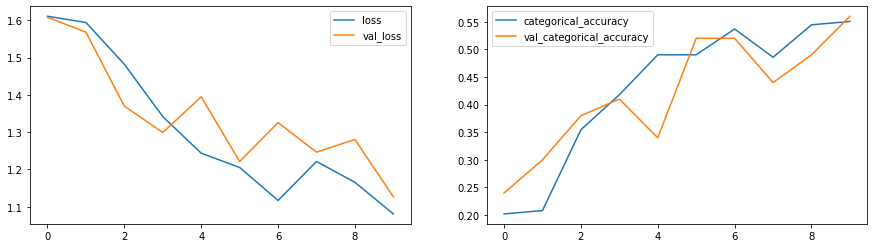

In [25]:
plot(model_history)

In [12]:
model_history = train_model(model, 64, epochs=30)

Source path =  /datasets/Project_data/train ; batch size = 64 ;foldersize =  663
Epoch 1/30


2022-07-08 00:46:19.339821: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.6147 - categorical_accuracy: 0.1916 Source path =  /datasets/Project_data/val ; batch size = 64 ;foldersize =  100
Batch:  2 ; Size: 36

Epoch 00001: val_loss improved from inf to 1.60923, saving model to model_init_2022-07-0800_46_04.863812/model-00001-1.61466-0.19155-1.60923-0.19000.h5
11/11 [==============================] - 156s 15s/step - loss: 1.6147 - categorical_accuracy: 0.1916 - val_loss: 1.6092 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.6052 - categorical_accuracy: 0.1916 Batch:  2 ; Size: 36
Batch:  2 ; Size: 36

Epoch 00002: val_loss improved from 1.60923 to 1.59355, saving model to model_init_2022-07-0800_46_04.863812/model-00002-1.60520-0.19155-1.59355-0.20000.h5
11/11 [==============================] - 153s 15s/step - loss: 1.6052 - categorical_accuracy: 0.1916 - val_loss: 1.5935 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30


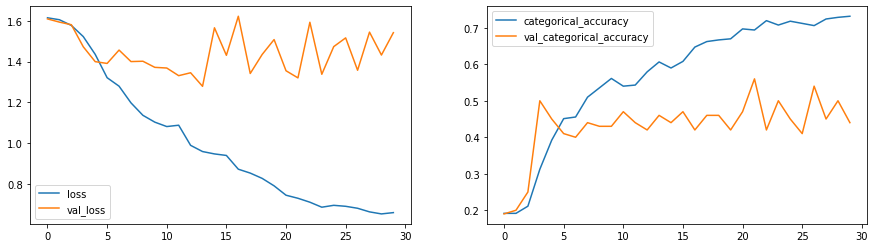

In [13]:
plot(model_history)

In [41]:
model = Sequential()

model.add(Conv3D(
    32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 120, 120, 3)
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Conv3D(
    64, kernel_size=(3, 3, 3), activation='relu', strides=(1,1,1), padding='same'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Conv3D(
    128, kernel_size=(3, 3, 3), activation='relu', strides=(1,1,1), padding='same'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Conv3D(
    256, kernel_size=(3, 3, 3), activation='relu', strides=(1,1,1), padding='same'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

num_epochs = 25
compile_summary(model)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 32)   0         
 )                                                               
                                                                 
 dropout_15 (Dropout)        (None, 14, 59, 59, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 59, 59, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 29, 29, 64)    0         
 3D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 7, 29, 29, 64)    

In [42]:
model_history = train_model(model, 32, epochs=num_epochs)

Source path =  /datasets/Project_data/train ; batch size = 32 ;foldersize =  663
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6112 - categorical_accuracy: 0.2142Source path =  /datasets/Project_data/val ; batch size = 32 ;foldersize =  100
Batch:  4 ; Size: 4

Epoch 00001: val_loss improved from inf to 1.60935, saving model to model_init_2022-07-0704_10_56.939836/model-00001-1.61120-0.21418-1.60935-0.20000.h5
21/21 [==============================] - 155s 8s/step - loss: 1.6112 - categorical_accuracy: 0.2142 - val_loss: 1.6094 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.2021Batch:  4 ; Size: 4

Epoch 00002: val_loss improved from 1.60935 to 1.60863, saving model to model_init_2022-07-0704_10_56.939836/model-00002-1.60990-0.20211-1.60863-0.21000.h5
21/21 [==============================] - 155s 8s/step - loss: 1.6099 - categorical_accuracy: 0.2021 - val_loss: 1

In [18]:
model = Sequential()

model.add(Conv3D(
    16, kernel_size=(3, 3, 3), activation='relu', input_shape=(x, y, z, channel)
    ))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#model.add(Dropout(0.2))
model.add(Conv3D(
    32, kernel_size=(3, 3, 3), activation='relu', padding='same'
    ))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


#model.add(Dropout(0.2))
model.add(Conv3D(
    64, kernel_size=(3, 3, 3), activation='relu', padding='same'
    ))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Dropout(0.2))
model.add(Conv3D(
    128, kernel_size=(3, 3, 3), activation='relu', padding='same'
    ))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

num_epochs = 30
compile_summary(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 28, 118, 118, 16)  1312      
                                                                 
 batch_normalization_14 (Bat  (None, 28, 118, 118, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 28, 59, 59, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 28, 59, 59, 32)    13856     
                                                                 
 batch_normalization_15 (Bat  (None, 28, 59, 59, 32)   128       
 chNormalization)                                                
                                                      

In [19]:
model_history = train_model(model, 30, epochs=num_epochs)

Source path =  /datasets/Project_data/train ; batch size = 30 ;foldersize =  663
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.7366 - categorical_accuracy: 0.4691Source path =  /datasets/Project_data/val ; batch size = 30 ;foldersize =  100
Batch:  4 ; Size: 10

Epoch 00001: val_loss improved from inf to 5.27778, saving model to model_init_2022-07-0905_35_14.696032/model-00001-2.73657-0.46908-5.27778-0.16000.h5
23/23 [==============================] - 77s 3s/step - loss: 2.7366 - categorical_accuracy: 0.4691 - val_loss: 5.2778 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 2/30
22/23 [===========================>..] - ETA: 2s - loss: 2.0948 - categorical_accuracy: 0.6864Batch:  4 ; Size: 10

Epoch 00002: val_loss did not improve from 5.27778
23/23 [==============================] - 76s 3s/step - loss: 2.0939 - categorical_accuracy: 0.6863 - val_loss: 8.3389 - val_categorical_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 3/30
22/23 [=========================

## #3 Try a Conv3D model with l2 regularization.


In [23]:
model = Sequential()

model.add(Conv3D(16, kernel_size = (3,3,3),padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(1,2,2)))
#model.add(Dropout(0.05))

model.add(Conv3D(32, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.05))

model.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.3))

model.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(32,kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.23))
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.3))
model.add(Dense(num_classes, activation = 'softmax'))

compile_summary(model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_29 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 30, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 30, 60, 60, 32)    13856     
                                                                 
 batch_normalization_30 (Bat  (None, 30, 60, 60, 32)  

In [28]:
model_history = train_model(model, 30, 30)

Source path =  /datasets/Project_data/train ; batch size = 30 ;foldersize =  663
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.9957 - categorical_accuracy: 0.4449Source path =  /datasets/Project_data/val ; batch size = 30 ;foldersize =  100
Batch:  4 ; Size: 10

Epoch 00001: val_loss improved from inf to 2.25894, saving model to model_init_2022-07-0906_20_00.235227/model-00001-1.99574-0.44495-2.25894-0.28000.h5
23/23 [==============================] - 42s 2s/step - loss: 1.9957 - categorical_accuracy: 0.4449 - val_loss: 2.2589 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5922 - categorical_accuracy: 0.6380Batch:  4 ; Size: 10

Epoch 00002: val_loss did not improve from 2.25894
23/23 [==============================] - 40s 2s/step - loss: 1.5922 - categorical_accuracy: 0.6380 - val_loss: 2.6897 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 3/30
22/23 [=========================

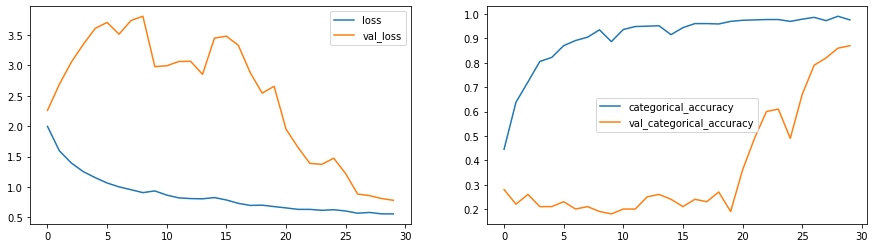

In [29]:
plot(model_history)

## #4 Try with an alternative model.

In [52]:
# Define x (number of frames), y (height) and z (width) 
x = 30
y = 60
z = 60
channel = 3

In [20]:
model2 = Sequential()
model2.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x, y, z, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(BatchNormalization())


model2.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(BatchNormalization())


model2.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

compile_summary(model2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 activation_26 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 conv3d_27 (Conv3D)          (None, 30, 120, 120, 32)  27680     
                                                                 
 activation_27 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 15, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 15, 60, 60, 32)   128       
 chNormalization)                                     

In [ ]:
modl2_history = train_model(model2, batch_size_mn=32, epochs=30)

Source path =  /datasets/Project_data/train ; batch size = 32 ;foldersize =  663
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.4598 - categorical_accuracy: 0.4163Source path =  /datasets/Project_data/val ; batch size = 32 ;foldersize =  100
Batch:  4 ; Size: 4

Epoch 00001: val_loss improved from inf to 1.62719, saving model to model_init_2022-07-0804_11_01.224991/model-00001-1.45982-0.41629-1.62719-0.16000.h5
21/21 [==============================] - 171s 8s/step - loss: 1.4598 - categorical_accuracy: 0.4163 - val_loss: 1.6272 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9676 - categorical_accuracy: 0.6380Batch:  4 ; Size: 4

Epoch 00002: val_loss did not improve from 1.62719
21/21 [==============================] - 161s 8s/step - loss: 0.9676 - categorical_accuracy: 0.6380 - val_loss: 1.6358 - val_categorical_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 3/30
21/21 [=========================

Not seeing any improvements in above model.

## #5 Transfer learning using EfficientNetB0

In [12]:
# Use EfficientNetB0

base_model = efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(y,z,channel))

# freeze all convolutional layers
#for layer in base_model.layers:
    #layer.trainable = False

# add a global spatial average pooling layer
op = base_model.output
op = GlobalAveragePooling2D()(op)

# create the fine tuned base model
base_model = Model(inputs=base_model.input, outputs=op)

# this is the model we will train
effnet_model = Sequential()

# Add the base model on top of the final model
effnet_model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
effnet_model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))

# GRU
effnet_model.add(GRU(256, activation='relu', dropout=0.5))

# output layer
effnet_model.add(Dense(num_classes, activation = 'softmax'))

compile_summary(effnet_model)

2022-07-07 01:44:02.792627: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-07 01:44:02.792697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 1280)       4049571   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1280)       0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 256)               1181184   
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 5,232,040
Trainable params: 5,190,017
Non-trainable params: 42,023
_________________________________________________________________
None


In [14]:
# Define x (number of frames), y (height) and z (width) 
x = 30
y = 120
z = 120
channel = 3
batch_size_5 = 64

## Increase the epochs to 30

In [63]:
effnet_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=get_callbacks(), validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.2713 - categorical_accuracy: 0.4706
Epoch 00001: saving model to model_init_2022-07-0508_11_04.811970/model-00001-1.27126-0.47059-1.99425-0.12500.h5
11/11 [==============================] - 39s 4s/step - loss: 1.2713 - categorical_accuracy: 0.4706 - val_loss: 1.9942 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.0895 - categorical_accuracy: 0.5775
Epoch 00002: saving model to model_init_2022-07-0508_11_04.811970/model-00002-1.08946-0.57754-2.27068-0.25000.h5
11/11 [==============================] - 37s 4s/step - loss: 1.0895 - categorical_accuracy: 0.5775 - val_loss: 2.2707 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.1065 - categorical_accuracy: 0.5668
Epoch 00003: saving model to model_init_2022-07-0508_11_04.811970/model-00003-1.10647-0.56684-1.53477-0.25000.h5
11/11 [====

## #6 Experiment with mobilenet transfer learning

In [18]:
# Define x (number of frames), y (height) and z (width) 
x = 30
y = 60
z = 60
channel = 3
batch_size_mn = 32

# Get base model
mobilenet_base_model = mobilenet.MobileNet(weights="imagenet", include_top=False)

mobilenet_model = Sequential()
mobilenet_model.add(TimeDistributed(mobilenet_base_model, input_shape=(x,y,z,channel)))

mobilenet_model.add(TimeDistributed(BatchNormalization()))
mobilenet_model.add(TimeDistributed(GlobalAveragePooling2D()))
mobilenet_model.add(TimeDistributed(Flatten()))

mobilenet_model.add(GRU(64))
mobilenet_model.add(Dropout(0.25))

mobilenet_model.add(Dense(64, activation='relu'))
mobilenet_model.add(Dropout(0.25))

mobilenet_model.add(Dense(num_classes, activation='softmax'))

compile_summary(mobilenet_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1, 1, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 64)               

In [19]:
mobilenet_history= train_model(mobilenet_model, batch_size_mn, epochs=30)

Source path =  /datasets/Project_data/train ; batch size = 32 ;foldersize =  663
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5467 - categorical_accuracy: 0.3424Source path =  /datasets/Project_data/val ; batch size = 32 ;foldersize =  100
Batch:  4 ; Size: 4
21/21 [==============================] - 169s 8s/step - loss: 1.5467 - categorical_accuracy: 0.3424 - val_loss: 2.0657 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 161s 8s/step - loss: 0.9357 - categorical_accuracy: 0.6486 - val_loss: 1.7478 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 163s 8s/step - loss: 0.5083 - categorical_accuracy: 0.8250 - val_loss: 2.2795 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.3032 - categorical_accuracy: 0.9216Batch:  4 ; Size: 4
Batch:  4 ; Size: 4
21/21 [==============================] - 157s 8

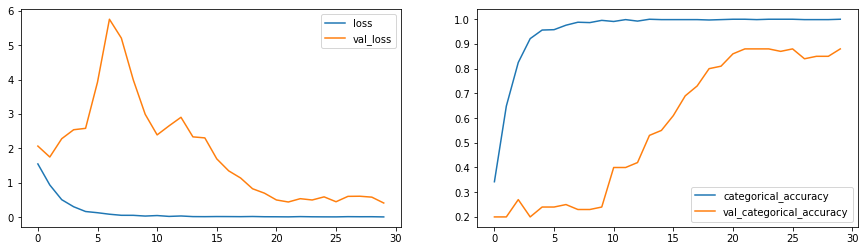

In [21]:
plot(mobilenet_history)

In [10]:
# Define x (number of frames), y (height) and z (width) 
x = 30
y = 60
z = 60
channel = 3
batch_size_mn = 32

# Get base model
mobilenet_base_model = mobilenet.MobileNet(weights="imagenet", include_top=False)

mobilenet_model = Sequential()
mobilenet_model.add(TimeDistributed(mobilenet_base_model, input_shape=(x,y,z,channel)))

mobilenet_model.add(TimeDistributed(BatchNormalization()))
mobilenet_model.add(TimeDistributed(GlobalAveragePooling2D()))
mobilenet_model.add(TimeDistributed(Flatten()))

mobilenet_model.add(GRU(128))
mobilenet_model.add(Dropout(0.25))

mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.25))

mobilenet_model.add(Dense(num_classes, activation='softmax'))

compile_summary(mobilenet_model)

2022-07-07 07:14:39.955602: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-07 07:14:39.955695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 1, 1, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1, 1, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [ ]:
# Run one more time in order to save the model
mobilenet_history= train_model(mobilenet_model, batch_size_mn, epochs=30, cropimage=True)

Source path =  /datasets/Project_data/train ; batch size = 32 ;foldersize =  663
Epoch 1/30


2022-07-07 07:14:57.243443: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


20/21 [===========================>..] - ETA: 6s - loss: 1.4485 - categorical_accuracy: 0.3938 

## #7 CNN with LSTM

In [30]:
x = 30
y = 120
z = 120
channel = 3
batch_size_mn = 64

cnn_lstm_model = Sequential()

cnn_lstm_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(x,y,z,channel)))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(256))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(Dense(512,activation='relu'))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

compile_summary(cnn_lstm_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 60, 60, 32)  

In [31]:
cnn_lstm_history = train_model(cnn_lstm_model, batch_size_mn, epochs=25)

Source path =  /datasets/Project_data/train ; batch size = 64 ;foldersize =  663
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.4151 - categorical_accuracy: 0.3891 Source path =  /datasets/Project_data/val ; batch size = 64 ;foldersize =  100
Batch:  2 ; Size: 36

Epoch 00001: val_loss improved from inf to 1.62704, saving model to model_init_2022-07-0703_26_23.835237/model-00001-1.41514-0.38914-1.62704-0.16000.h5
11/11 [==============================] - 157s 15s/step - loss: 1.4151 - categorical_accuracy: 0.3891 - val_loss: 1.6270 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.0152 - categorical_accuracy: 0.5822 Batch:  2 ; Size: 36
Batch:  2 ; Size: 36

Epoch 00002: val_loss improved from 1.62704 to 1.62105, saving model to model_init_2022-07-0703_26_23.835237/model-00002-1.01519-0.58220-1.62105-0.22000.h5
11/11 [==============================] - 150s 15s/step - loss: 1.0152 - categorical_acc

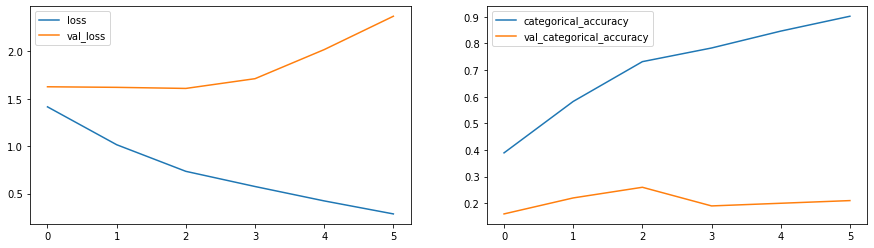

In [32]:
plot(cnn_lstm_history)

## The model is overfitting. 

In [33]:
x = 30
y = 120
z = 120
channel = 3
batch_size_mn = 64
learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)

cnn_lstm_model = Sequential()

cnn_lstm_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(x,y,z,channel)))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(256))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(Dense(512,activation='relu'))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

compile_summary(cnn_lstm_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 30, 60, 60, 16)    0         
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                           

In [34]:
cnn_lstm_history = train_model(cnn_lstm_model, batch_size_mn, epochs=20)

Source path =  /datasets/Project_data/train ; batch size = 64 ;foldersize =  663
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.4548 - categorical_accuracy: 0.3529 Source path =  /datasets/Project_data/val ; batch size = 64 ;foldersize =  100
Batch:  2 ; Size: 36

Epoch 00001: val_loss improved from inf to 1.66870, saving model to model_init_2022-07-0703_43_15.204025/model-00001-1.45477-0.35294-1.66870-0.16000.h5
11/11 [==============================] - 159s 16s/step - loss: 1.4548 - categorical_accuracy: 0.3529 - val_loss: 1.6687 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.1751 - categorical_accuracy: 0.5189 Batch:  2 ; Size: 36
Batch:  2 ; Size: 36

Epoch 00002: val_loss did not improve from 1.66870
11/11 [==============================] - 151s 15s/step - loss: 1.1751 - categorical_accuracy: 0.5189 - val_loss: 1.8742 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
11/11 [======

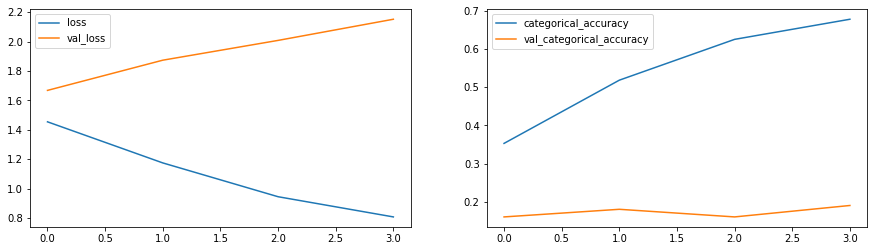

In [35]:
plot(cnn_lstm_history)

## #8 Reduce batch size to 32 and modify to use GRU

In [30]:
x = 30
y = 120
z = 120
channel = 3
batch_size_mn = 32

cnn_lstm_model = Sequential()

cnn_lstm_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(x,y,z,channel)))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
cnn_lstm_model.add(TimeDistributed(BatchNormalization()))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(GRU(128))
cnn_lstm_model.add(Dropout(0.25))

cnn_lstm_model.add(Dense(64,activation='relu'))
cnn_lstm_model.add(Dropout(0.25))

cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

compile_summary(cnn_lstm_model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [31]:
cnn_lstm_history = train_model(cnn_lstm_model, batch_size_mn, epochs=30)

Source path =  /datasets/Project_data/train ; batch size = 32 ;foldersize =  663
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7293 - categorical_accuracy: 0.1885Source path =  /datasets/Project_data/val ; batch size = 32 ;foldersize =  100
Batch:  4 ; Size: 4

Epoch 00001: val_loss improved from inf to 1.61592, saving model to model_init_2022-07-0906_44_07.035795/model-00001-1.72928-0.18854-1.61592-0.22000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.7293 - categorical_accuracy: 0.1885 - val_loss: 1.6159 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5664 - categorical_accuracy: 0.2685Batch:  4 ; Size: 4

Epoch 00002: val_loss did not improve from 1.61592
21/21 [==============================] - 40s 2s/step - loss: 1.5664 - categorical_accuracy: 0.2685 - val_loss: 1.6347 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/30
21/21 [===========================

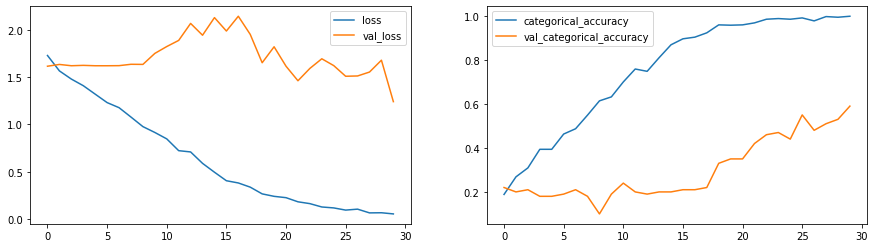

In [32]:
plot(cnn_lstm_history)

In [33]:
# Run 20 more epochs
cnn_lstm_history = train_model(cnn_lstm_model, 30, epochs=20)

Source path =  /datasets/Project_data/train ; batch size = 30 ;foldersize =  663
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.0421 - categorical_accuracy: 0.9970Source path =  /datasets/Project_data/val ; batch size = 30 ;foldersize =  100
Batch:  4 ; Size: 10

Epoch 00001: val_loss improved from inf to 1.33981, saving model to model_init_2022-07-0907_07_54.852112/model-00001-0.04206-0.99698-1.33981-0.56000.h5
23/23 [==============================] - 40s 2s/step - loss: 0.0421 - categorical_accuracy: 0.9970 - val_loss: 1.3398 - val_categorical_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.0794 - categorical_accuracy: 0.9894Batch:  4 ; Size: 10

Epoch 00002: val_loss improved from 1.33981 to 0.93908, saving model to model_init_2022-07-0907_07_54.852112/model-00002-0.07941-0.98944-0.93908-0.70000.h5
23/23 [==============================] - 39s 2s/step - loss: 0.0794 - categorical_accuracy: 0.9894 - val_los

In [34]:
val_path = '/datasets/Project_data/val'
t = np.random.permutation(val_doc)
img_idx = [x for x in range(0,x)]
batch_data, batch_labels = generate_batch(val_path, t, 0, 64, x, y, z, channel, img_idx)
preds = cnn_lstm_model.predict_on_batch(
    batch_data
)
print(preds)
print(batch_labels)

[[0.2731642  0.48912087 0.11599845 0.05272903 0.06898737]
 [0.8240017  0.04202146 0.04677978 0.03537983 0.05181723]
 [0.12213811 0.7381359  0.11318547 0.00822298 0.01831753]
 [0.04757187 0.0931705  0.6245805  0.12405267 0.11062445]
 [0.23396441 0.2677333  0.17977548 0.26425007 0.05427675]
 [0.05816684 0.02600128 0.23695543 0.60080326 0.0780732 ]
 [0.23972562 0.60406584 0.10184596 0.02842317 0.02593936]
 [0.6654518  0.07140061 0.08545646 0.0502883  0.12740284]
 [0.20543465 0.05643212 0.10610322 0.13732123 0.4947088 ]
 [0.16876452 0.02881315 0.04942748 0.06963798 0.68335694]
 [0.04090759 0.14275162 0.5494151  0.12567401 0.1412517 ]
 [0.02460019 0.11847471 0.5132357  0.24840936 0.09528004]
 [0.15375118 0.66097134 0.1300461  0.0304666  0.02476476]
 [0.4618237  0.20231336 0.12092683 0.10756455 0.10737157]
 [0.2037075  0.57781655 0.14532755 0.04097106 0.03217724]
 [0.08876768 0.02025034 0.20840952 0.5816117  0.10096081]
 [0.07030801 0.5319707  0.31111977 0.04315451 0.04344704]
 [0.6635989  0

#  Augmentation
To see the impact of additional data

In [35]:
cnn_lstm_history = train_model(cnn_lstm_model, batch_size_mn, epochs=30, augment=True)

Source path =  /datasets/Project_data/train ; batch size = 32 ;foldersize =  663
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.0077 - categorical_accuracy: 1.0000Source path =  /datasets/Project_data/val ; batch size = 32 ;foldersize =  100
Batch:  4 ; Size: 4

Epoch 00001: val_loss improved from inf to 0.75238, saving model to model_init_2022-07-0907_31_52.284943/model-00001-0.00772-1.00000-0.75238-0.83000.h5
21/21 [==============================] - 40s 2s/step - loss: 0.0077 - categorical_accuracy: 1.0000 - val_loss: 0.7524 - val_categorical_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.0078 - categorical_accuracy: 1.0000Batch:  4 ; Size: 4

Epoch 00002: val_loss improved from 0.75238 to 0.63021, saving model to model_init_2022-07-0907_31_52.284943/model-00002-0.00785-1.00000-0.63021-0.84000.h5
21/21 [==============================] - 40s 2s/step - loss: 0.0078 - categorical_accuracy: 1.0000 - val_loss:

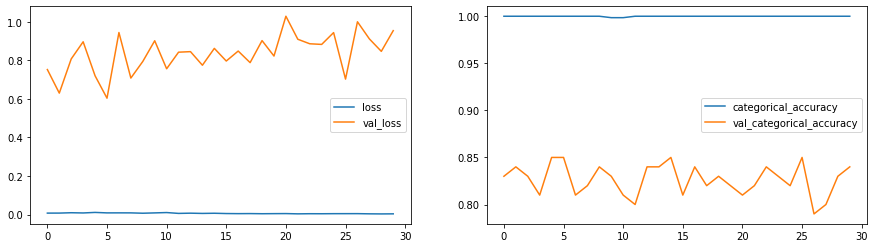

In [36]:
plot(cnn_lstm_history)

## Model #3 is giving the best results with 87% validation accuracy.